In [2]:
import pandas as pd
!pip install pennylane --upgrade
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

Requirement already up-to-date: pennylane in /opt/conda/lib/python3.8/site-packages (0.22.2)


/opt/conda/lib/python3.8/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2022-04-03 07:57:45.876890: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-03 07:57:45.876936: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [13]:
# This is the chess engine file, nothing interesting here so just run this cell and scroll down to data processing
"""
Storing all the information about the current state of chess game.
Determining valid moves at current state.
It will keep move log.
"""


class GameState:
    """
    Represents the state of a chess game, providing the position of the board, valid moves, etc.
    """
    def __init__(self):
        """
        Board is an 8x8 2d list, each element in list has 2 characters.
        The first character represents the color of the piece: 'b' or 'w'.
        The second character represents the type of the piece: 'R', 'N', 'B', 'Q', 'K' or 'p'.
        "--" represents an empty space with no piece.
        """
        self.board = [
            ["bR", "bN", "bB", "bQ", "bK", "bB", "bN", "bR"],
            ["bp", "bp", "bp", "bp", "bp", "bp", "bp", "bp"],
            ["--", "--", "--", "--", "--", "--", "--", "--"],
            ["--", "--", "--", "--", "--", "--", "--", "--"],
            ["--", "--", "--", "--", "--", "--", "--", "--"],
            ["--", "--", "--", "--", "--", "--", "--", "--"],
            ["wp", "wp", "wp", "wp", "wp", "wp", "wp", "wp"],
            ["wR", "wN", "wB", "wQ", "wK", "wB", "wN", "wR"]]
        self.moveFunctions = {"p": self.get_pawn_moves, "R": self.get_rook_moves, "N": self.get_knight_moves,
                              "B": self.get_bishop_moves, "Q": self.get_queen_moves, "K": self.get_king_moves}
        self.white_to_move = True
        self.move_log = []
        self.white_king_location = (7, 4)
        self.black_king_location = (0, 4)
        self.checkmate = False
        self.stalemate = False
        self.in_check = False
        self.pins = []
        self.checks = []
        self.enpassant_possible = ()  # coordinates for the square where en-passant capture is possible
        self.enpassant_possible_log = [self.enpassant_possible]
        self.current_castling_rights = CastleRights(True, True, True, True)
        self.castle_rights_log = [CastleRights(self.current_castling_rights.wks, self.current_castling_rights.bks,
                                               self.current_castling_rights.wqs, self.current_castling_rights.bqs)]
        self.FEN_translator = {"r": "bR", "n": "bN", "b": "bB", "q": "bQ", "k": "bK", "p": "bp",
                               "R": "wR", "N": "wN", "B": "wB", "Q": "wQ", "K": "wK", "P": "wp"}

    def FEN_to_board(self, FEN: str):
        """
        Converts FEN representation to the board convention in this engine.
        """
        row = 0
        column = 0
        self.board = [
            ["bR", "bN", "bB", "bQ", "bK", "bB", "bN", "bR"],
            ["bp", "bp", "bp", "bp", "bp", "bp", "bp", "bp"],
            ["--", "--", "--", "--", "--", "--", "--", "--"],
            ["--", "--", "--", "--", "--", "--", "--", "--"],
            ["--", "--", "--", "--", "--", "--", "--", "--"],
            ["--", "--", "--", "--", "--", "--", "--", "--"],
            ["wp", "wp", "wp", "wp", "wp", "wp", "wp", "wp"],
            ["wR", "wN", "wB", "wQ", "wK", "wB", "wN", "wR"]]
        for i in range(0, len(FEN)):
            piece = FEN[i]
            if piece == "/":
                row += 1
                column = 0
            if piece in {"0", "1", "2", "3", "4", "5", "6", "7", "8"}:
                value = int(piece)
                for _ in range(0, value):
                    self.board[row][column] = "--"
                    column += 1
            elif piece in self.FEN_translator:
                pc = self.FEN_translator[piece]
                self.board[row][column] = pc
                column += 1
            elif piece == " ":
                piece = FEN[i+1]
                self.white_to_move = True if piece == " w" else False
                break

    def board_to_FEN(self, board: list):
        """
        Converts from the board convention in this engine to the conventional FEN representation.
        """
        FEN = ''
        board_translator = {self.FEN_translator[key]: key for key in self.FEN_translator}
        row = 0
        for chess_row in board:
            empty_counter = 0
            row += 1
            column = 0
            for piece in chess_row:
                column += 1
                if piece == "--":
                    empty_counter += 1
                if empty_counter > 0 and (piece != "--" or column == 8):
                    FEN += str(empty_counter)
                    empty_counter = 0
                if piece != "--":
                    piece_FEN = board_translator[piece]
                    FEN += piece_FEN
            if row != 8:
                FEN += '/'
            else:
                FEN += " w" if self.white_to_move else " b"
        return FEN

    def make_move(self, move) -> None:
        """
        Takes a Move as a parameter and executes it.
        """
        self.board[move.start_row][move.start_col] = "--"
        self.board[move.end_row][move.end_col] = move.piece_moved
        self.move_log.append(move)  # log the move so we can undo it later
        self.white_to_move = not self.white_to_move  # switch players
        # update king's location if moved
        if move.piece_moved == "wK":
            self.white_king_location = (move.end_row, move.end_col)
        elif move.piece_moved == "bK":
            self.black_king_location = (move.end_row, move.end_col)

        # pawn promotion
        if move.is_pawn_promotion:
            # if not is_AI:
            #    promoted_piece = input("Promote to Q, R, B, or N:") #take this to UI later
            #    self.board[move.end_row][move.end_col] = move.piece_moved[0] + promoted_piece
            # else:
            self.board[move.end_row][move.end_col] = move.piece_moved[0] + "Q"

        # enpassant move
        if move.is_enpassant_move:
            self.board[move.start_row][move.end_col] = "--"  # capturing the pawn

        # update enpassant_possible variable
        if move.piece_moved[1] == "p" and abs(move.start_row - move.end_row) == 2:  # only on 2 square pawn advance
            self.enpassant_possible = ((move.start_row + move.end_row) // 2, move.start_col)
        else:
            self.enpassant_possible = ()

        # castle move
        if move.is_castle_move:
            if move.end_col - move.start_col == 2:  # king-side castle move
                self.board[move.end_row][move.end_col - 1] = self.board[move.end_row][
                    move.end_col + 1]  # moves the rook to its new square
                self.board[move.end_row][move.end_col + 1] = '--'  # erase old rook
            else:  # queen-side castle move
                self.board[move.end_row][move.end_col + 1] = self.board[move.end_row][
                    move.end_col - 2]  # moves the rook to its new square
                self.board[move.end_row][move.end_col - 2] = '--'  # erase old rook

        self.enpassant_possible_log.append(self.enpassant_possible)

        # update castling rights - whenever it is a rook or king move
        self.update_castle_rights(move)
        self.castle_rights_log.append(CastleRights(self.current_castling_rights.wks, self.current_castling_rights.bks,
                                                   self.current_castling_rights.wqs, self.current_castling_rights.bqs))

    def undo_move(self):
        """
        Undo the last move
        """
        if len(self.move_log) != 0:  # make sure that there is a move to undo
            move = self.move_log.pop()
            self.board[move.start_row][move.start_col] = move.piece_moved
            self.board[move.end_row][move.end_col] = move.piece_captured
            self.white_to_move = not self.white_to_move  # swap players
            # update the king's position if needed
            if move.piece_moved == "wK":
                self.white_king_location = (move.start_row, move.start_col)
            elif move.piece_moved == "bK":
                self.black_king_location = (move.start_row, move.start_col)
            # undo en passant move
            if move.is_enpassant_move:
                self.board[move.end_row][move.end_col] = "--"  # leave landing square blank
                self.board[move.start_row][move.end_col] = move.piece_captured

            self.enpassant_possible_log.pop()
            self.enpassant_possible = self.enpassant_possible_log[-1]

            # undo castle rights
            self.castle_rights_log.pop()  # get rid of the new castle rights from the move we are undoing
            self.current_castling_rights = self.castle_rights_log[
                -1]  # set the current castle rights to the last one in the list
            # undo the castle move
            if move.is_castle_move:
                if move.end_col - move.start_col == 2:  # king-side
                    self.board[move.end_row][move.end_col + 1] = self.board[move.end_row][move.end_col - 1]
                    self.board[move.end_row][move.end_col - 1] = '--'
                else:  # queen-side
                    self.board[move.end_row][move.end_col - 2] = self.board[move.end_row][move.end_col + 1]
                    self.board[move.end_row][move.end_col + 1] = '--'
            self.checkmate = False
            self.stalemate = False

    def update_castle_rights(self, move):
        """
        Update the castle rights given the move
        """
        if move.piece_captured == "wR":
            if move.end_col == 0:  # left rook
                self.current_castling_rights.wqs = False
            elif move.end_col == 7:  # right rook
                self.current_castling_rights.wks = False
        elif move.piece_captured == "bR":
            if move.end_col == 0:  # left rook
                self.current_castling_rights.bqs = False
            elif move.end_col == 7:  # right rook
                self.current_castling_rights.bks = False

        if move.piece_moved == 'wK':
            self.current_castling_rights.wqs = False
            self.current_castling_rights.wks = False
        elif move.piece_moved == 'bK':
            self.current_castling_rights.bqs = False
            self.current_castling_rights.bks = False
        elif move.piece_moved == 'wR':
            if move.start_row == 7:
                if move.start_col == 0:  # left rook
                    self.current_castling_rights.wqs = False
                elif move.start_col == 7:  # right rook
                    self.current_castling_rights.wks = False
        elif move.piece_moved == 'bR':
            if move.start_row == 0:
                if move.start_col == 0:  # left rook
                    self.current_castling_rights.bqs = False
                elif move.start_col == 7:  # right rook
                    self.current_castling_rights.bks = False

    def get_valid_moves(self):
        """
        All moves considering checks.
        """
        temp_castle_rights = CastleRights(self.current_castling_rights.wks, self.current_castling_rights.bks,
                                          self.current_castling_rights.wqs, self.current_castling_rights.bqs)
        # advanced algorithm
        moves = []
        self.in_check, self.pins, self.checks = self.check_for_pins_and_checks()

        if self.white_to_move:
            king_row = self.white_king_location[0]
            king_col = self.white_king_location[1]
        else:
            king_row = self.black_king_location[0]
            king_col = self.black_king_location[1]
        if self.in_check:
            if len(self.checks) == 1:  # only 1 check, block the check or move the king
                moves = self.get_all_possible_moves()
                # to block the check you must put a piece into one of the squares between the enemy piece and your king
                check = self.checks[0]  # check information
                check_row = check[0]
                check_col = check[1]
                piece_checking = self.board[check_row][check_col]
                valid_squares = []  # squares that pieces can move to
                # if knight, must capture the knight or move your king, other pieces can be blocked
                if piece_checking[1] == "N":
                    valid_squares = [(check_row, check_col)]
                else:
                    for i in range(1, 8):
                        valid_square = (king_row + check[2] * i,
                                        king_col + check[3] * i)  # check[2] and check[3] are the check directions
                        valid_squares.append(valid_square)
                        if valid_square[0] == check_row and valid_square[
                            1] == check_col:  # once you get to piece and check
                            break
                # get rid of any moves that don't block check or move king
                for i in range(len(moves) - 1, -1, -1):  # iterate through the list backwards when removing elements
                    if moves[i].piece_moved[1] != "K":  # move doesn't move king so it must block or capture
                        if not (moves[i].end_row,
                                moves[i].end_col) in valid_squares:  # move doesn't block or capture piece
                            moves.remove(moves[i])
            else:  # double check, king has to move
                self.get_king_moves(king_row, king_col, moves)
        else:  # not in check - all moves are fine
            moves = self.get_all_possible_moves()
            if self.white_to_move:
                self.get_castle_moves(self.white_king_location[0], self.white_king_location[1], moves)
            else:
                self.get_castle_moves(self.black_king_location[0], self.black_king_location[1], moves)

        if len(moves) == 0:
            if self.in_check:
                self.checkmate = True
            else:
                # TODO stalemate on repeated moves
                self.stalemate = True
        else:
            self.checkmate = False
            self.stalemate = False

        self.current_castling_rights = temp_castle_rights
        return moves

    def in_check(self):
        """
        Determine if a current player is in check
        """
        if self.white_to_move:
            return self.square_under_attack(self.white_king_location[0], self.white_king_location[1])
        else:
            return self.square_under_attack(self.black_king_location[0], self.black_king_location[1])

    def square_under_attack(self, row, col):
        """
        Determine if enemy can attack the square row col
        """
        self.white_to_move = not self.white_to_move  # switch to opponent's point of view
        opponents_moves = self.get_all_possible_moves()
        self.white_to_move = not self.white_to_move
        for move in opponents_moves:
            if move.end_row == row and move.end_col == col:  # square is under attack
                return True
        return False

    def get_all_possible_moves(self):
        """
        All moves without considering checks.
        """
        moves = []
        for row in range(len(self.board)):
            for col in range(len(self.board[row])):
                turn = self.board[row][col][0]
                if (turn == "w" and self.white_to_move) or (turn == "b" and not self.white_to_move):
                    piece = self.board[row][col][1]
                    self.moveFunctions[piece](row, col, moves)  # calls appropriate move function based on piece type
        return moves

    def check_for_pins_and_checks(self):
        pins = []  # squares pinned and the direction its pinned from
        checks = []  # squares where enemy is applying a check
        in_check = False
        if self.white_to_move:
            enemy_color = "b"
            ally_color = "w"
            start_row = self.white_king_location[0]
            start_col = self.white_king_location[1]
        else:
            enemy_color = "w"
            ally_color = "b"
            start_row = self.black_king_location[0]
            start_col = self.black_king_location[1]
        # check outwards from king for pins and checks, keep track of pins
        directions = ((-1, 0), (0, -1), (1, 0), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1))
        for j in range(len(directions)):
            direction = directions[j]
            possible_pin = ()  # reset possible pins
            for i in range(1, 8):
                end_row = start_row + direction[0] * i
                end_col = start_col + direction[1] * i
                if 0 <= end_row <= 7 and 0 <= end_col <= 7:
                    end_piece = self.board[end_row][end_col]
                    if end_piece[0] == ally_color and end_piece[1] != "K":
                        if possible_pin == ():  # first allied piece could be pinned
                            possible_pin = (end_row, end_col, direction[0], direction[1])
                        else:  # 2nd allied piece - no check or pin from this direction
                            break
                    elif end_piece[0] == enemy_color:
                        enemy_type = end_piece[1]
                        # 5 possibilities in this complex conditional
                        # 1.) orthogonally away from king and piece is a rook
                        # 2.) diagonally away from king and piece is a bishop
                        # 3.) 1 square away diagonally from king and piece is a pawn
                        # 4.) any direction and piece is a queen
                        # 5.) any direction 1 square away and piece is a king
                        if (0 <= j <= 3 and enemy_type == "R") or (4 <= j <= 7 and enemy_type == "B") or (
                                i == 1 and enemy_type == "p" and (
                                (enemy_color == "w" and 6 <= j <= 7) or (enemy_color == "b" and 4 <= j <= 5))) or (
                                enemy_type == "Q") or (i == 1 and enemy_type == "K"):
                            if possible_pin == ():  # no piece blocking, so check
                                in_check = True
                                checks.append((end_row, end_col, direction[0], direction[1]))
                                break
                            else:  # piece blocking so pin
                                pins.append(possible_pin)
                                break
                        else:  # enemy piece not applying checks
                            break
                else:
                    break  # off board
        # check for knight checks
        knight_moves = ((-2, -1), (-2, 1), (-1, 2), (1, 2), (2, -1), (2, 1), (-1, -2), (1, -2))
        for move in knight_moves:
            end_row = start_row + move[0]
            end_col = start_col + move[1]
            if 0 <= end_row <= 7 and 0 <= end_col <= 7:
                end_piece = self.board[end_row][end_col]
                if end_piece[0] == enemy_color and end_piece[1] == "N":  # enemy knight attacking a king
                    in_check = True
                    checks.append((end_row, end_col, move[0], move[1]))
        return in_check, pins, checks

    def get_pawn_moves(self, row, col, moves):
        """
        Get all the pawn moves for the pawn located at row, col and add the moves to the list.
        """
        piece_pinned = False
        pin_direction = ()
        for i in range(len(self.pins) - 1, -1, -1):
            if self.pins[i][0] == row and self.pins[i][1] == col:
                piece_pinned = True
                pin_direction = (self.pins[i][2], self.pins[i][3])
                self.pins.remove(self.pins[i])
                break

        if self.white_to_move:
            move_amount = -1
            start_row = 6
            enemy_color = "b"
            king_row, king_col = self.white_king_location
        else:
            move_amount = 1
            start_row = 1
            enemy_color = "w"
            king_row, king_col = self.black_king_location

        if self.board[row + move_amount][col] == "--":  # 1 square pawn advance
            if not piece_pinned or pin_direction == (move_amount, 0):
                moves.append(Move((row, col), (row + move_amount, col), self.board))
                if row == start_row and self.board[row + 2 * move_amount][col] == "--":  # 2 square pawn advance
                    moves.append(Move((row, col), (row + 2 * move_amount, col), self.board))
        if col - 1 >= 0:  # capture to the left
            if not piece_pinned or pin_direction == (move_amount, -1):
                if self.board[row + move_amount][col - 1][0] == enemy_color:
                    moves.append(Move((row, col), (row + move_amount, col - 1), self.board))
                if (row + move_amount, col - 1) == self.enpassant_possible:
                    attacking_piece = blocking_piece = False
                    if king_row == row:
                        if king_col < col:  # king is left of the pawn
                            # inside: between king and the pawn;
                            # outside: between pawn and border;
                            inside_range = range(king_col + 1, col - 1)
                            outside_range = range(col + 1, 8)
                        else:  # king right of the pawn
                            inside_range = range(king_col - 1, col, -1)
                            outside_range = range(col - 2, -1, -1)
                        for i in inside_range:
                            if self.board[row][i] != "--":  # some piece beside en-passant pawn blocks
                                blocking_piece = True
                        for i in outside_range:
                            square = self.board[row][i]
                            if square[0] == enemy_color and (square[1] == "R" or square[1] == "Q"):
                                attacking_piece = True
                            elif square != "--":
                                blocking_piece = True
                    if not attacking_piece or blocking_piece:
                        moves.append(Move((row, col), (row + move_amount, col - 1), self.board, is_enpassant_move=True))
        if col + 1 <= 7:  # capture to the right
            if not piece_pinned or pin_direction == (move_amount, +1):
                if self.board[row + move_amount][col + 1][0] == enemy_color:
                    moves.append(Move((row, col), (row + move_amount, col + 1), self.board))
                if (row + move_amount, col + 1) == self.enpassant_possible:
                    attacking_piece = blocking_piece = False
                    if king_row == row:
                        if king_col < col:  # king is left of the pawn
                            # inside: between king and the pawn;
                            # outside: between pawn and border;
                            inside_range = range(king_col + 1, col)
                            outside_range = range(col + 2, 8)
                        else:  # king right of the pawn
                            inside_range = range(king_col - 1, col + 1, -1)
                            outside_range = range(col - 1, -1, -1)
                        for i in inside_range:
                            if self.board[row][i] != "--":  # some piece beside en-passant pawn blocks
                                blocking_piece = True
                        for i in outside_range:
                            square = self.board[row][i]
                            if square[0] == enemy_color and (square[1] == "R" or square[1] == "Q"):
                                attacking_piece = True
                            elif square != "--":
                                blocking_piece = True
                    if not attacking_piece or blocking_piece:
                        moves.append(Move((row, col), (row + move_amount, col + 1), self.board, is_enpassant_move=True))

    def get_rook_moves(self, row, col, moves):
        """
        Get all the rook moves for the rook located at row, col and add the moves to the list.
        """
        piece_pinned = False
        pin_direction = ()
        for i in range(len(self.pins) - 1, -1, -1):
            if self.pins[i][0] == row and self.pins[i][1] == col:
                piece_pinned = True
                pin_direction = (self.pins[i][2], self.pins[i][3])
                if self.board[row][col][
                    1] != "Q":  # can't remove queen from pin on rook moves, only remove it on bishop moves
                    self.pins.remove(self.pins[i])
                break

        directions = ((-1, 0), (0, -1), (1, 0), (0, 1))  # up, left, down, right
        enemy_color = "b" if self.white_to_move else "w"
        for direction in directions:
            for i in range(1, 8):
                end_row = row + direction[0] * i
                end_col = col + direction[1] * i
                if 0 <= end_row <= 7 and 0 <= end_col <= 7:  # check for possible moves only in boundaries of the board
                    if not piece_pinned or pin_direction == direction or pin_direction == (
                            -direction[0], -direction[1]):
                        end_piece = self.board[end_row][end_col]
                        if end_piece == "--":  # empty space is valid
                            moves.append(Move((row, col), (end_row, end_col), self.board))
                        elif end_piece[0] == enemy_color:  # capture enemy piece
                            moves.append(Move((row, col), (end_row, end_col), self.board))
                            break
                        else:  # friendly piece
                            break
                else:  # off board
                    break

    def get_knight_moves(self, row, col, moves):
        """
        Get all the knight moves for the knight located at row col and add the moves to the list.
        """
        piece_pinned = False
        for i in range(len(self.pins) - 1, -1, -1):
            if self.pins[i][0] == row and self.pins[i][1] == col:
                piece_pinned = True
                self.pins.remove(self.pins[i])
                break

        knight_moves = ((-2, -1), (-2, 1), (-1, 2), (1, 2), (2, -1), (2, 1), (-1, -2),
                        (1, -2))  # up/left up/right right/up right/down down/left down/right left/up left/down
        ally_color = "w" if self.white_to_move else "b"
        for move in knight_moves:
            end_row = row + move[0]
            end_col = col + move[1]
            if 0 <= end_row <= 7 and 0 <= end_col <= 7:
                if not piece_pinned:
                    end_piece = self.board[end_row][end_col]
                    if end_piece[0] != ally_color:  # so its either enemy piece or empty square
                        moves.append(Move((row, col), (end_row, end_col), self.board))

    def get_bishop_moves(self, row, col, moves):
        """
        Get all the bishop moves for the bishop located at row col and add the moves to the list.
        """
        piece_pinned = False
        pin_direction = ()
        for i in range(len(self.pins) - 1, -1, -1):
            if self.pins[i][0] == row and self.pins[i][1] == col:
                piece_pinned = True
                pin_direction = (self.pins[i][2], self.pins[i][3])
                self.pins.remove(self.pins[i])
                break

        directions = ((-1, -1), (-1, 1), (1, 1), (1, -1))  # diagonals: up/left up/right down/right down/left
        enemy_color = "b" if self.white_to_move else "w"
        for direction in directions:
            for i in range(1, 8):
                end_row = row + direction[0] * i
                end_col = col + direction[1] * i
                if 0 <= end_row <= 7 and 0 <= end_col <= 7:  # check if the move is on board
                    if not piece_pinned or pin_direction == direction or pin_direction == (
                            -direction[0], -direction[1]):
                        end_piece = self.board[end_row][end_col]
                        if end_piece == "--":  # empty space is valid
                            moves.append(Move((row, col), (end_row, end_col), self.board))
                        elif end_piece[0] == enemy_color:  # capture enemy piece
                            moves.append(Move((row, col), (end_row, end_col), self.board))
                            break
                        else:  # friendly piece
                            break
                else:  # off board
                    break

    def get_queen_moves(self, row, col, moves):
        """
        Get all the queen moves for the queen located at row col and add the moves to the list.
        """
        self.get_bishop_moves(row, col, moves)
        self.get_rook_moves(row, col, moves)

    def get_king_moves(self, row, col, moves):
        """
        Get all the king moves for the king located at row col and add the moves to the list.
        """
        row_moves = (-1, -1, -1, 0, 0, 1, 1, 1)
        col_moves = (-1, 0, 1, -1, 1, -1, 0, 1)
        ally_color = "w" if self.white_to_move else "b"
        for i in range(8):
            end_row = row + row_moves[i]
            end_col = col + col_moves[i]
            if 0 <= end_row <= 7 and 0 <= end_col <= 7:
                end_piece = self.board[end_row][end_col]
                if end_piece[0] != ally_color:  # not an ally piece - empty or enemy
                    # place king on end square and check for checks
                    if ally_color == "w":
                        self.white_king_location = (end_row, end_col)
                    else:
                        self.black_king_location = (end_row, end_col)
                    in_check, pins, checks = self.check_for_pins_and_checks()
                    if not in_check:
                        moves.append(Move((row, col), (end_row, end_col), self.board))
                    # place king back on original location
                    if ally_color == "w":
                        self.white_king_location = (row, col)
                    else:
                        self.black_king_location = (row, col)

    def get_castle_moves(self, row, col, moves):
        """
        Generate all valid castle moves for the king at (row, col) and add them to the list of moves.
        """
        if self.square_under_attack(row, col):
            return  # can't castle while in check
        if (self.white_to_move and self.current_castling_rights.wks) or (
                not self.white_to_move and self.current_castling_rights.bks):
            self.get_kingside_castle_moves(row, col, moves)
        if (self.white_to_move and self.current_castling_rights.wqs) or (
                not self.white_to_move and self.current_castling_rights.bqs):
            self.get_queenside_castle_moves(row, col, moves)

    def get_kingside_castle_moves(self, row, col, moves):
        if self.board[row][col + 1] == '--' and self.board[row][col + 2] == '--':
            if not self.square_under_attack(row, col + 1) and not self.square_under_attack(row, col + 2):
                moves.append(Move((row, col), (row, col + 2), self.board, is_castle_move=True))

    def get_queenside_castle_moves(self, row, col, moves):
        if self.board[row][col - 1] == '--' and self.board[row][col - 2] == '--' and self.board[row][col - 3] == '--':
            if not self.square_under_attack(row, col - 1) and not self.square_under_attack(row, col - 2):
                moves.append(Move((row, col), (row, col - 2), self.board, is_castle_move=True))


class CastleRights:
    """
    Recors the castle rights for both the white and black kings.
    """
    def __init__(self, wks, bks, wqs, bqs):
        self.wks = wks
        self.bks = bks
        self.wqs = wqs
        self.bqs = bqs


class Move:
    # in chess, fields on the board are described by two symbols,
    # one of them being number between 1-8 (which is corresponding to rows)
    # and the second one being a letter between a-f (corresponding to columns),
    # in order to use this notation we need to map our [row][col] coordinates
    # to match the ones used in the original chess game
    ranks_to_rows = {"1": 7, "2": 6, "3": 5, "4": 4,
                     "5": 3, "6": 2, "7": 1, "8": 0}
    rows_to_ranks = {v: k for k, v in ranks_to_rows.items()}
    files_to_cols = {"a": 0, "b": 1, "c": 2, "d": 3,
                     "e": 4, "f": 5, "g": 6, "h": 7}
    cols_to_files = {v: k for k, v in files_to_cols.items()}

    def __init__(self, start_square, end_square, board, is_enpassant_move=False, is_castle_move=False):
        self.start_row = start_square[0]
        self.start_col = start_square[1]
        self.end_row = end_square[0]
        self.end_col = end_square[1]
        self.piece_moved = board[self.start_row][self.start_col]
        self.piece_captured = board[self.end_row][self.end_col]
        # pawn promotion
        self.is_pawn_promotion = (self.piece_moved == "wp" and self.end_row == 0) or (
                self.piece_moved == "bp" and self.end_row == 7)
        # en passant
        self.is_enpassant_move = is_enpassant_move
        if self.is_enpassant_move:
            self.piece_captured = "wp" if self.piece_moved == "bp" else "bp"
        # castle move
        self.is_castle_move = is_castle_move

        self.is_capture = self.piece_captured != "--"
        self.moveID = self.start_row * 1000 + self.start_col * 100 + self.end_row * 10 + self.end_col

    def __eq__(self, other):
        """
        Overriding the equals method.
        """
        if isinstance(other, Move):
            return self.moveID == other.moveID
        return False

    def get_chess_notation(self):
        if self.is_pawn_promotion:
            return self.get_rank_file(self.end_row, self.end_col) + "Q"
        if self.is_castle_move:
            if self.end_col == 1:
                return "0-0-0"
            else:
                return "0-0"
        if self.is_enpassant_move:
            return self.get_rank_file(self.start_row, self.start_col)[0] + "x" + self.get_rank_file(self.end_row,
                                                                                                self.end_col) + " e.p."
        if self.piece_captured != "--":
            if self.piece_moved[1] == "p":
                return self.get_rank_file(self.start_row, self.start_col)[0] + "x" + self.get_rank_file(self.end_row,
                                                                                                    self.end_col)
            else:
                return self.piece_moved[1] + "x" + self.get_rank_file(self.end_row, self.end_col)
        else:
            if self.piece_moved[1] == "p":
                return self.get_rank_file(self.end_row, self.end_col)
            else:
                return self.piece_moved[1] + self.get_rank_file(self.end_row, self.end_col)

        # TODO Disambiguating moves

    def get_rank_file(self, row, col):
        return self.cols_to_files[col] + self.rows_to_ranks[row]

    def __str__(self):
        if self.is_castle_move:
            return "0-0" if self.end_col == 6 else "0-0-0"

        end_square = self.get_rank_file(self.end_row, self.end_col)

        if self.piece_moved[1] == "p":
            if self.is_capture:
                return self.cols_to_files[self.start_col] + "x" + end_square
            else:
                return end_square + "Q" if self.is_pawn_promotion else end_square

        move_string = self.piece_moved[1]
        if self.is_capture:
            move_string += "x"
        return move_string + end_square


In [6]:
def get_specific_dataframe(theme1: str = 'endgame', theme2: str = 'mate',
                           file_name: str = 'lichess_db_puzzle.csv',
                           chunksize: int = 100000) -> pd.DataFrame:
    """
    Return a dataframe that consists of puzzles with the given two themes and the chess puzzle
     database file.

    :param theme1: one of the chess themes the user wants from the chess database
    :param theme2: the other chess theme the user wants from the chess database
    :param file_name: the name and the location of the chess database file
    :param chunksize: the size of the df (for some reason jupyter breaks when we deal with the full data)
    :return: a specific dataframe that consists of chess database with theme1 and theme2
    """

    # the list that contains all the dataframes
    list_of_dataframes = []

    for df in pd.read_csv(file_name, chunksize=chunksize):
        # process your data frame here
        # then add the current data frame into the list
        list_of_dataframes.append(df)
        break

    # if you want all the dataframes together, here it is
    result = pd.concat(list_of_dataframes)
    df.columns = ['PuzzleId', 'FEN', 'Moves', 'Rating', 'RatingDeviation', 'Popularity', 'NbPlays', 'Themes', 'GameUrl']
    specific_df = df.loc[df['Themes'].str.contains(theme1, na=False) & df['Themes'].str.contains(theme2, na=False)]
    return specific_df

In [8]:
def preprocess_data(df: pd.DataFrame, size: int, train_ratio: float = 0.8) \
        -> (list, list):
    """
    Return an 8x8 pixel version of each FEN (a FEN is a standard notation for describing a
    particular board position of a chess game) in the chess puzzle data frame, where each pixel
    represents the piece in that position on the board given by the FEN.

    :param df: the specific or nonspecific chess puzzle dataframe.
    :param size: the maximum size we want the returned list to be.
    :param train_ratio: train_size / df.size; the ratio of the size of the train data
    :return: 8x8 pixel of the chess board, where each pixel represents a piece of each FEN in df.
    """
    size = size if size < df.size else df.size  # to ensure the size is less than size of df
    converted_data = []

    # for each FEN in the chess puzzle database, first create a GameState object so that it follows
    # the rules of chess. Then, convert the board of a GameState object into a 8x8 pixel, where
    # each pixel is one-hot encoded version of a piece on the board.
    for i in range(0, size):
        FEN = df.iloc[i]['FEN']
        moves = df.iloc[i]['Moves'].split(' ')
        game_state = GameState()
        game_state.FEN_to_board(FEN)  # convert Lichess puzzle FEN into a GameState object
        # Lichess puzzle occurs after the first move, so we have to execute this code:
        game_state.make_move(Move([ord(moves[0][0]) - 97, int(moves[0][1]) - 1],
                                  [ord(moves[0][2]) - 97, int(moves[0][3]) - 1], game_state.board))
        if game_state.white_to_move:  # for now, our model will only train for puzzles for white
            converted_data.append(board_to_pixels(game_state.board))  # pixelated chess board

    train_data = converted_data[:round(len(converted_data) * train_ratio)]
    test_data = converted_data[len(train_data):]
    return (train_data, test_data)

In [81]:
def board_to_pixels(board: list) -> list:
    """
    Given the chess board, one-hot encode all of the pieces so that the machine learning algorithm
    is not biased. After encoding, return the board as an image; that is, every piece (or an empty
    square) is a pixel on the board, and the board is an 8x8 pixel.
    :param board: position of the board of a GameState object.
    :return: pixelated (converted into a 8x8 pixel image) version of the boardç
    """
    piece_to_list = {'wp': np.array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'bp': np.array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
                      'wN': np.array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'bN': np.array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
                      'wB': np.array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'bB': np.array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
                      'wR': np.array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), 'bR': np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
                      'wQ': np.array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), 'bQ': np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
                      'wK': np.array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), 'bK': np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
                      '--': np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}
    pixelated_board = []
    for row in board:
        pixelated_row = []
        for piece in row:
            pixelated_row.append(sum(piece_to_list[piece]))
        pixelated_board.append(pixelated_row)
    return pixelated_board

In [82]:
df = get_specific_dataframe()
train_chess_data, test_chess_data = preprocess_data(df, 10000)

In [64]:
# Let's see one FEN of a chess board, and how we converted it

In [65]:
df['FEN'].iloc[0]

'4r1k1/5ppp/r1p5/p1n1RP2/8/2P2N1P/2P3P1/3R2K1 b - - 0 21'

In [83]:
train_chess_data[0]

[[tensor(0., requires_grad=True),
  tensor(0., requires_grad=True),
  tensor(0., requires_grad=True),
  tensor(0., requires_grad=True),
  tensor(1., requires_grad=True),
  tensor(0., requires_grad=True),
  tensor(1., requires_grad=True),
  tensor(0., requires_grad=True)],
 [tensor(0., requires_grad=True),
  tensor(0., requires_grad=True),
  tensor(0., requires_grad=True),
  tensor(0., requires_grad=True),
  tensor(0., requires_grad=True),
  tensor(1., requires_grad=True),
  tensor(1., requires_grad=True),
  tensor(1., requires_grad=True)],
 [tensor(1., requires_grad=True),
  tensor(0., requires_grad=True),
  tensor(1., requires_grad=True),
  tensor(0., requires_grad=True),
  tensor(0., requires_grad=True),
  tensor(0., requires_grad=True),
  tensor(0., requires_grad=True),
  tensor(0., requires_grad=True)],
 [tensor(1., requires_grad=True),
  tensor(0., requires_grad=True),
  tensor(1., requires_grad=True),
  tensor(0., requires_grad=True),
  tensor(1., requires_grad=True),
  tensor(1.

In [67]:
n_epochs = 50  # Number of optimization epochs
n_layers = 1  # Number of random layers

SAVE_PATH = "quanvolution/"  # Data saving folder
qua_preprocess = True # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)  # Seed for NumPy random number generator
tf.random.set_seed(0)  # Seed for TensorFlow random number generator

# Add extra dimension for convolution channels
train_chess_data = np.array(train_chess_data[..., tf.newaxis], requires_grad=False)
test_chess_data = np.array(test_chess_data[..., tf.newaxis], requires_grad=False)

TypeError: list indices must be integers or slices, not tuple

In [7]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [8]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [11]:
if qua_preprocess == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


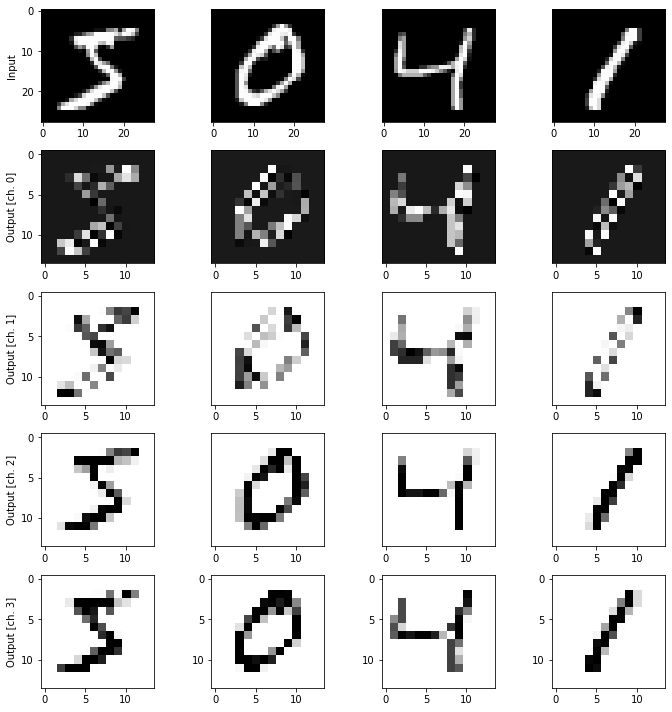

In [12]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [26]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [27]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - loss: 2.9375 - accuracy: 0.1000 - val_loss: 2.3202 - val_accuracy: 0.1333 - 518ms/epoch - 40ms/step
Epoch 2/30
13/13 - 0s - loss: 2.1949 - accuracy: 0.2400 - val_loss: 2.0703 - val_accuracy: 0.3000 - 52ms/epoch - 4ms/step
Epoch 3/30
13/13 - 0s - loss: 1.7597 - accuracy: 0.4400 - val_loss: 2.0198 - val_accuracy: 0.2333 - 51ms/epoch - 4ms/step
Epoch 4/30
13/13 - 0s - loss: 1.3667 - accuracy: 0.5400 - val_loss: 1.7065 - val_accuracy: 0.5000 - 54ms/epoch - 4ms/step
Epoch 5/30
13/13 - 0s - loss: 1.1528 - accuracy: 0.7400 - val_loss: 1.6063 - val_accuracy: 0.4667 - 56ms/epoch - 4ms/step
Epoch 6/30
13/13 - 0s - loss: 0.9744 - accuracy: 0.7800 - val_loss: 1.5678 - val_accuracy: 0.4667 - 50ms/epoch - 4ms/step
Epoch 7/30
13/13 - 0s - loss: 0.7525 - accuracy: 0.8600 - val_loss: 1.4511 - val_accuracy: 0.5667 - 58ms/epoch - 4ms/step
Epoch 8/30
13/13 - 0s - loss: 0.5989 - accuracy: 1.0000 - val_loss: 1.3385 - val_accuracy: 0.6000 - 52ms/epoch - 4ms/step
Epoch 9/30
13/13 - 0s 

In [28]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)


Epoch 1/30
13/13 - 1s - loss: 2.4150 - accuracy: 0.0600 - val_loss: 2.2431 - val_accuracy: 0.1667 - 546ms/epoch - 42ms/step
Epoch 2/30
13/13 - 0s - loss: 2.0335 - accuracy: 0.3000 - val_loss: 2.1039 - val_accuracy: 0.2667 - 52ms/epoch - 4ms/step
Epoch 3/30
13/13 - 0s - loss: 1.7260 - accuracy: 0.5600 - val_loss: 1.9831 - val_accuracy: 0.3333 - 51ms/epoch - 4ms/step
Epoch 4/30
13/13 - 0s - loss: 1.4866 - accuracy: 0.7200 - val_loss: 1.8568 - val_accuracy: 0.5000 - 51ms/epoch - 4ms/step
Epoch 5/30
13/13 - 0s - loss: 1.2821 - accuracy: 0.8200 - val_loss: 1.7372 - val_accuracy: 0.5333 - 52ms/epoch - 4ms/step
Epoch 6/30
13/13 - 0s - loss: 1.1158 - accuracy: 0.9000 - val_loss: 1.6398 - val_accuracy: 0.6333 - 58ms/epoch - 4ms/step
Epoch 7/30
13/13 - 0s - loss: 0.9696 - accuracy: 0.9200 - val_loss: 1.5669 - val_accuracy: 0.6667 - 56ms/epoch - 4ms/step
Epoch 8/30
13/13 - 0s - loss: 0.8491 - accuracy: 0.9600 - val_loss: 1.4942 - val_accuracy: 0.6667 - 50ms/epoch - 4ms/step
Epoch 9/30
13/13 - 0s 

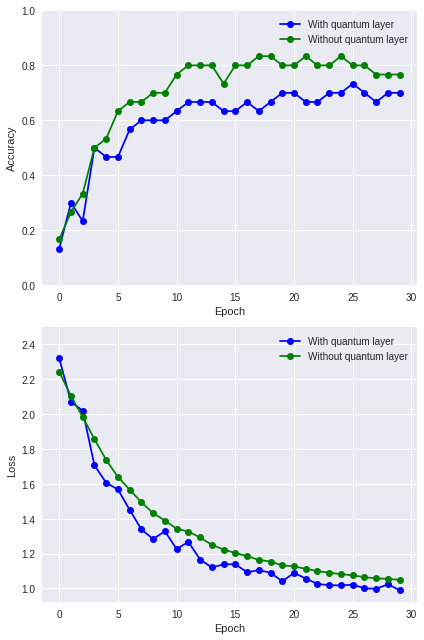

In [29]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()